In [1]:
    # ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.16.1
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# Gaussian inference and simulation

In [2]:
import matplotlib.pyplot  as plt
import numpy as np
import scipy as sp

In [3]:
def cholesky_sim(d0, Cd):
    L=np.linalg.cholesky(Cd)
    r = np.random.normal(0,1,d0.shape[0])
    d_star = d0 + np.dot(L,r)
    return d_star



def gaussian_rw(d0, Cd, r_in=[], is_chol=False, step = 0.1, method='gdm'):
    if is_chol:
        L = Cd
    else:
        L=np.linalg.cholesky(Cd)

    if len(r_in)==0:
        r = np.random.normal(0,1,d0.shape[0])
    else:
        if step>0:
            if method=='gdm':
                step_ang = step*np.pi/2
                r_new = np.random.normal(0,1,d0.shape[0])
                r = r_in*np.cos(step_ang) + r_new*np.sin(step_ang)
            else:
                n = Cd.shape[0]
                n_pert = int(np.ceil(step*n))
                r = r_in
                # select randomly n_pert of out n integer values
                i_pert = np.random.choice(n, n_pert, replace=False)
                r[i_pert]=np.random.normal(0,1,i_pert.shape)
        else:
            r = r_in

    d_star = d0 + np.dot(L,r)
    return d_star, r
    

def precal_distance(x,y):
    nx=len(x)
    ny=len(y)
    xx, yy = np.meshgrid(x,y)
    xx=xx.flatten()
    yy=yy.flatten()
    nd=xx.shape[0]
    d = np.sqrt((xx[:, np.newaxis] - xx[np.newaxis, :]) ** 2 + (yy[:, np.newaxis] - yy[np.newaxis, :]) ** 2)
    return d


def cov_gau(d,r,d_var):
    return d_var*np.exp(-3*d**2/r**2)

def cov_exp(d,r,d_var):
    return d_var*np.exp(-3*d/r)

def cov_nug(d,d_var):
    return d_var*(np.where(d == 0, 1.0, 0.0))
     
def cov_sph(d,r,d_var):

    C = 1-1.5*d/r + 0.5*(d/r)**3
    # set C=0 for d>r
    C = np.where(d > r, 0.0, C)
    C = d_var*C

    #np.where(d > r, 1.0, C)

    #return d_var*np.exp(-3*d**2/r**2)
    return C

def cov_cal(d,r,d_var, model='gaussian'):
    if model=='gaussian':
        return cov_gau(d,r,d_var)
    elif model=='exponential':
        return cov_exp(d,r,d_var)
    elif model=='spherical':
        return cov_sph(d,r,d_var)
    elif model=='nugget':
        return cov_nug(d,d_var)
    else:
        print('Model not found')
        return None

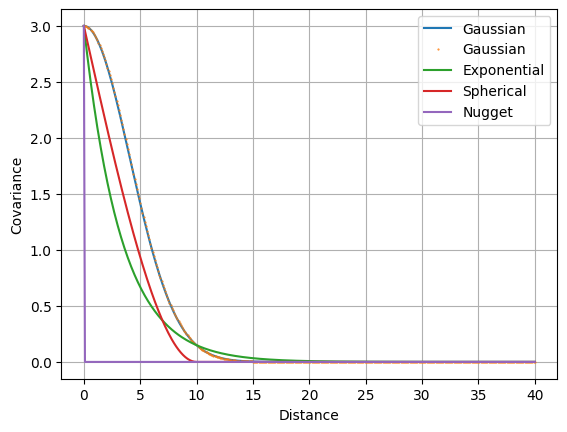

In [4]:
nd=401 
d = np.linspace(0,40,nd)

r = 10
v = 3
plt.figure()
plt.plot(d,cov_gau(d,r,v),label='Gaussian')
plt.plot(d,cov_cal(d,r,v, model='gaussian'),'.',label='Gaussian', markersize=1)
plt.plot(d,cov_exp(d,r,v),label='Exponential')
plt.plot(d,cov_sph(d,r,v),label='Spherical')
plt.plot(d,cov_nug(d,v),label='Nugget')
#plt.plot(d,cov_nug(d,r,v),label='Nugget')
plt.xlabel('Distance')
plt.ylabel('Covariance')
plt.legend()
plt.grid(True)

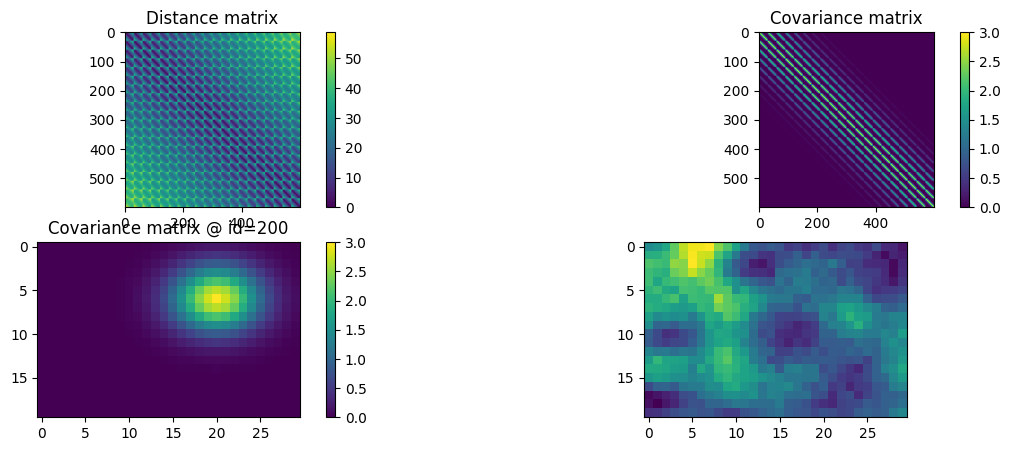

In [5]:


x = np.linspace(1,45,30)
y = np.linspace(1,40,20)
nx=len(x)
ny=len(y)


d = precal_distance(x,y)
nd=d.shape[0]

C = cov_exp(d,r=13,d_var=3)
d_nug = 0.1
C = cov_gau(d,r=13,d_var=3-d_nug)+cov_nug(d,d_nug)

C = cov_gau(d,r=13,d_var=3-d_nug)+cov_sph(d,1,d_nug)


plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
plt.imshow(d)
plt.colorbar()
plt.title('Distance matrix')
plt.subplot(2,2,2)
plt.imshow(C)
plt.colorbar()
plt.title('Covariance matrix')
plt.subplot(2,2,3)
id=200
plt.imshow(C[id].reshape((ny,nx)))
plt.colorbar()
plt.title('Covariance matrix @ id=%d' %(id))


m0 = np.zeros(nd)
m = cholesky_sim(m0,C)
m_2d = m.reshape((ny,nx))

plt.subplot(2,2,4)
plt.imshow(m_2d)




Text(0.5, 1.0, 'Difference')

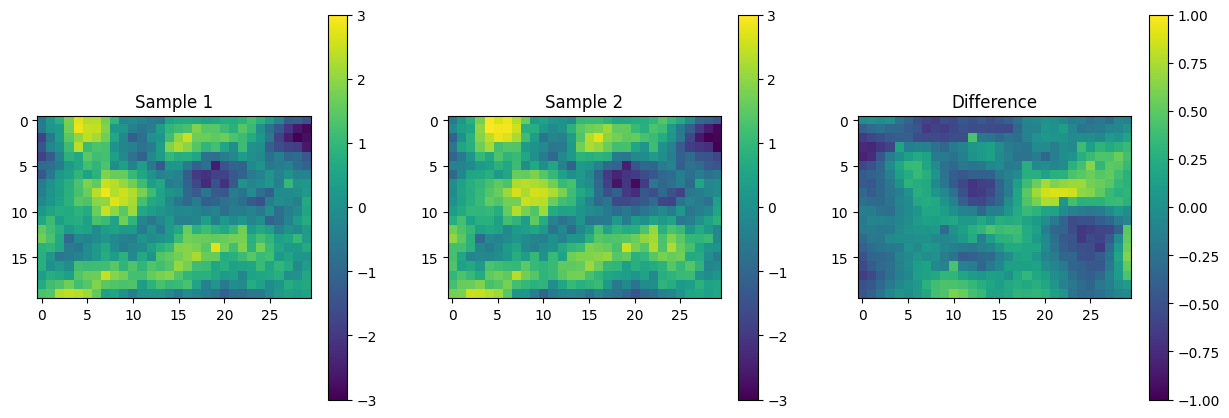

In [6]:

# Compue the cholesky decomposition of the covariance matrix
L=np.linalg.cholesky(C)

# Get starting model, and the random number for the starting model
m0 = np.zeros(nd)
m, r= gaussian_rw(m0,L,is_chol=True)
m_2d = m.reshape((ny,nx))

# Perturb the random numbers, by randomly recomputing npert random values, and compute a new realization
r_in = r.copy()
npert=20
for i in range(npert):
    i_pert = np.random.randint(0,nd)
    #i_pert = i
    r_in[i_pert] = np.random.normal(0,1)
m2, r2 = gaussian_rw(m0,L,is_chol=True, r_in = r_in)
m2_2d = m2.reshape((ny,nx))

# Compare the two realizations
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(m_2d, vmin=-3, vmax=3)
plt.colorbar()
plt.title('Sample 1')
plt.subplot(1,3,2)
plt.imshow(m2_2d, vmin=-3, vmax=3)
plt.colorbar()
plt.title('Sample 2')
plt.subplot(1,3,3)
plt.imshow(m_2d-m2_2d, vmin=-1, vmax=1)
plt.colorbar()
plt.title('Difference')



MovieWriter stderr:
ffmpeg: /home/au11687/miniconda3/envs/tf/lib/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /lib/x86_64-linux-gnu/libavfilter.so.9)
ffmpeg: /home/au11687/miniconda3/envs/tf/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/au11687/miniconda3/envs/tf/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/au11687/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/au11687/miniconda3/envs/tf/lib/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /lib/x86_64-linux-gnu/librubberband.so.2)
ffmpeg: /home/au11687/miniconda3/envs/tf/lib/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /lib/x86_64-linux-gnu/libplacebo.so.292)
ffmpeg: /home/au11687/miniconda3/envs/tf/lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (r

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1500x1000', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'RandomWalk_gdm.mp4']' returned non-zero exit status 1.

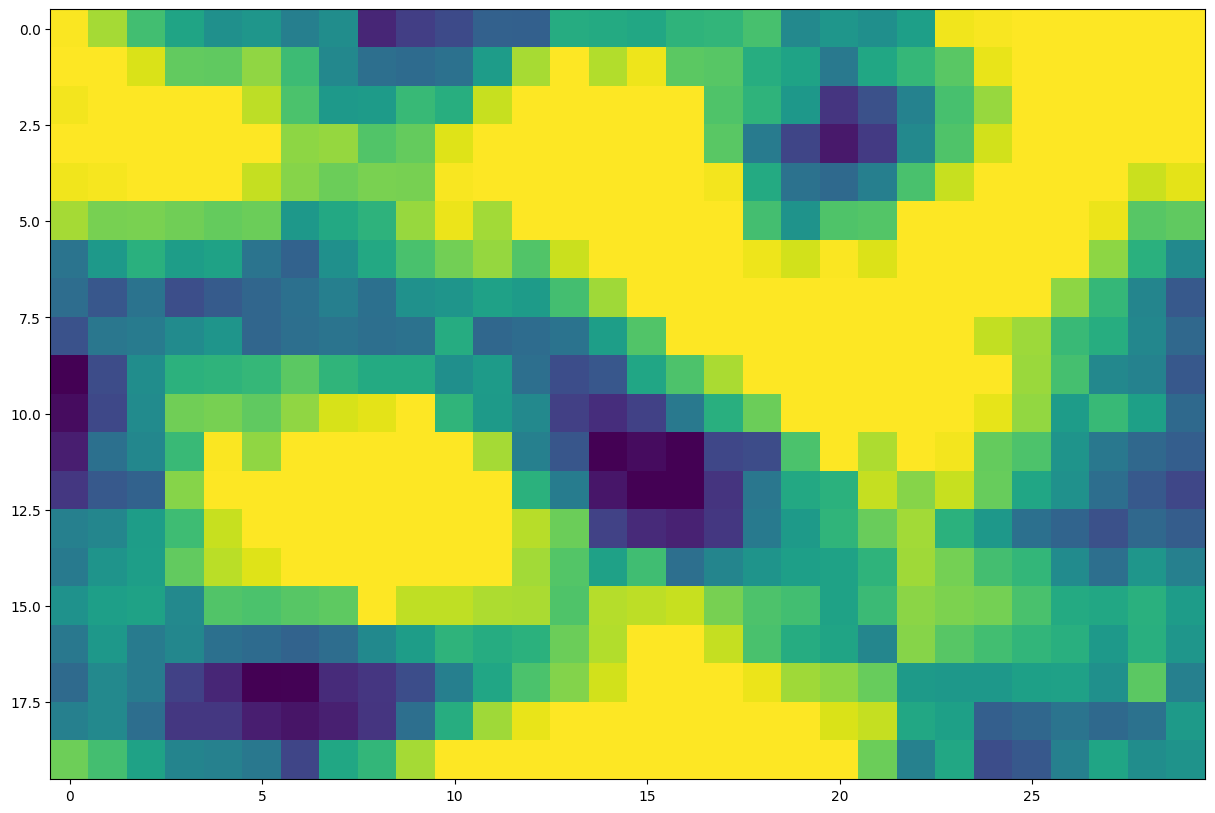

In [7]:
import matplotlib.animation as animation

L=np.linalg.cholesky(C)

m0 = np.zeros(nd)
m, r = gaussian_rw(m0, L, is_chol=True)
step = 0.1

fig = plt.figure(figsize=(15, 10))
ims = []
method = 'gdm'

for i in range(50):
    #print(i)
    m, r = gaussian_rw(m0, L, r_in=r, step=step, is_chol=True, method=method )
    im = plt.imshow(np.reshape(m, (ny, nx)), vmin=-2, vmax=2, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True)
ani.save('RandomWalk_%s.mp4'%(method), writer='ffmpeg')
#plt.show()